In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Моя линейная регрессия

Аналитическое решение

$$self.w = np.linalg.inv(Xtrain.T.dot(Xtrain)).dot(Xtrain.T).dot(y)$$

In [ ]:
class LinearRgression:
  def __init__(self, fit_intercept=True):
    self.fit_intercept = fit_intercept

  def fit(self, X, y):

    X_train = X.copy()
    
    if self.fit_intercept:

      X_b = np.c_[np.ones(X_train.shape), X_train]
      self.w = np.linalg.pinv(X_b).dot(y)

      return self
  def predict(self, X):

    X_train = X.copy()
    
    if self.fit_intercept:
      X_b = np.c_[np.ones(X_train.shape), X_train]
      y_pred = X_b.dot(self.w)

      return y_pred
  def getweights(self):
    return self.w

In [ ]:
X = 3 + 4 * np.random.rand(100, 1)
y = 1.5 * X + 10 + np.random.rand(100, 1)

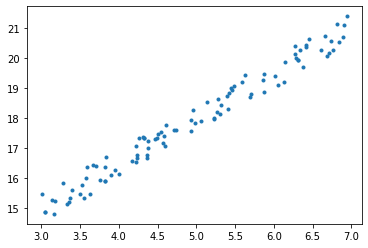

In [ ]:
plt.plot(X, y, '.')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = LinearRgression()

In [ ]:
model.fit(X_train, y_train)

In [ ]:
print(model.getweights())

[[10.44790896]
 [ 1.50880693]]


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_pred, y_test)

0.08353863122143154

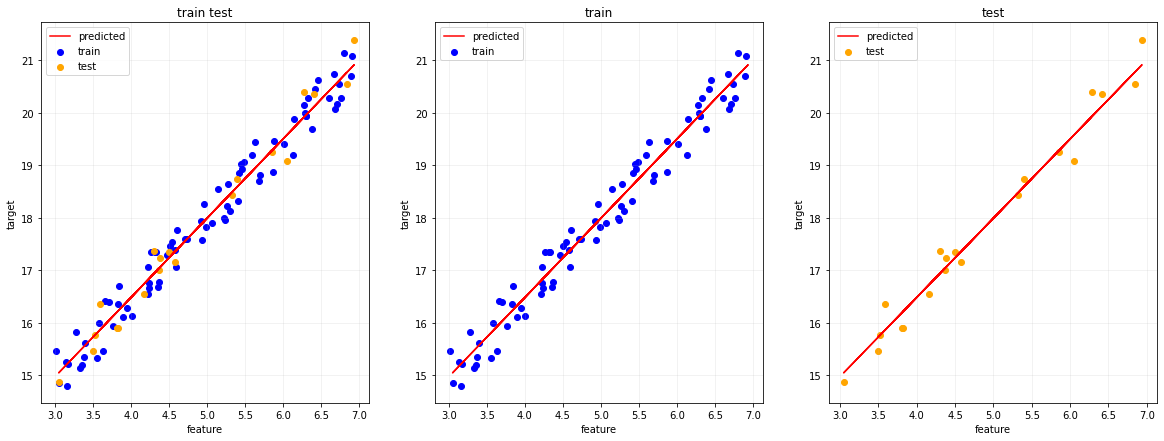

In [ ]:
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')


    plt.plot(X_test, model.predict(X_test), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

# Sklearn линейная регрессия

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()

In [ ]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mean_squared_error(y_pred, y_test)

0.08353863122143187

### Градиентная оптимизация

In [ ]:
class BoostLinearRegressor(LinearRgression):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.w = None


  def fit(self, X, y, lr=0.01, max_iter=100000):
    X_train = X.copy()
    if self.w is None:
      self.w = np.random.rand(X_train.shape[1] + 1, 1)  if self.fit_intercept else X_train.shape[1]
      X_b = np.c_[np.ones(X_train.shape), X_train] if self.fit_intercept else X_train

      self.losses = []

      for _ in range(max_iter):
        y_pred = X_b.dot(self.w)
        self.losses.append(mean_squared_error(y_pred, y))
        gradients = self._calc_gradient(X_b, y)
        assert gradients.shape == self.w.shape, f"gradient shape {gradients.shape} \
        is not equal weight shape {self.w.shape}"
        self.w -= lr * gradients

    return self
  
  def _calc_gradient(self, X, y):
    gradients = 2/X_train.shape[0] * X.T.dot(X.dot(self.w) - y)
    return gradients


  def get_losses(self):
    return self.losses

In [ ]:
model = BoostLinearRegressor(fit_intercept=True)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mean_squared_error(y_pred, y_test)

0.08353863122140731

### SGD

In [ ]:
class SGDLinearRegression(BoostLinearRegressor):
    def __init__(self, n_sample = 2, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.n_sample = n_sample

    def _calc_gradient(self, X, y):
        idx = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)
        gradients = 2* X[idx].T.dot(X[idx].dot(self.w) - y[idx])
        return gradients

In [ ]:
model = SGDLinearRegression(n_sample=2)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mean_squared_error(y_pred, y_test)

0.11431698865277924

In [ ]:
n_samples = [1, 2, 3, 6, 7]
for n in n_samples:
  model = SGDLinearRegression(n_sample=n)
  model.fit(X_train, y_train, max_iter=10000)
  y_pred = model.predict(X_test)
  print(mean_squared_error(y_pred, y_test))

0.1195478997528981
0.10814349518864522
0.10952359081159599
0.11088670005586562
0.12420258236404821


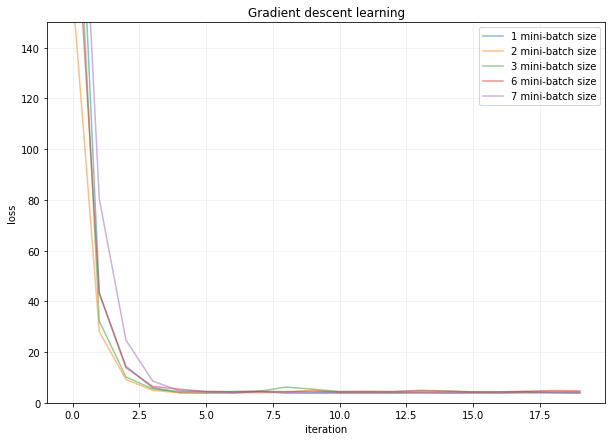

In [ ]:
plt.figure(figsize=(10, 7))

for ns in n_samples:
    l = SGDLinearRegression(n_sample=n).fit(X_train, y_train, max_iter=20).get_losses()
    plt.plot(l, alpha=0.5, label=f'{ns} mini-batch size')

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')

plt.legend()
plt.ylim((0, 150))
plt.grid(alpha=0.2)
plt.show()

### LR schedule - с понижением lr. адаптивный

In [ ]:
class SGDLinearRegressionSuper(BoostLinearRegressor):
    def __init__(self, t0=5, t1=50, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.t0 = t0
        self.t1 = t1

    
    def fit(self, X, y, lr=0.1, max_iter=10000):
      X_train = X.copy()
      if self.w is None:
        self.w = np.random.rand(X_train.shape[1] + 1, 1)  if self.fit_intercept else X_train.shape[1]
        X_b = np.c_[np.ones(X_train.shape), X_train] if self.fit_intercept else X_train

        self.losses = []

      m = X_b.shape[0]
      for epoch in range(1, max_iter):
        for i in range(m):
          random_idx = np.random.randint(m)
          xi = X_b[random_idx:random_idx+1]
          yi = y[random_idx:random_idx+1]
          gradients = 2 * xi.T.dot(xi.dot(self.w) - yi)
          t = epoch * m + i
          lr = self._learning_shedule(t)
          self.w = self.w - lr * gradients

      return self

    def _learning_shedule(self, t):
      return self.t0 /(t + self.t1)


In [ ]:
model = SGDLinearRegressionSuper()

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mean_squared_error(y_pred, y_test)

0.13671356998493653

### Логистическая регрессия


In [ ]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

class MyLogisticRegression(object):
    def __init__(self):
        self.w = None
    
    def fit(self, X, y, max_iter=100, lr=0.1):

        
        n, k = X.shape
        
        if self.w is None:
            self.w = np.random.randn(k + 1)
        
        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        
        losses = []
        
        for iter_num in range(max_iter):
            z = sigmoid(logit(X_train, self.w))
            grad = np.dot(X_train.T, (z - y)) / len(y)

            self.w -= grad * lr

            losses.append(self.__loss(y, z))
        
        return losses
        
    def predict_proba(self, X):

        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold
    
    def get_weights(self):
        return self.w
      
    def __loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

In [ ]:
class MyRidgeRegression(MyLinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
    
    def fit(self, X, y):
        n, m = X.shape
        X_train = X

        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))
        
        lambdaI = self.alpha * np.eye(X_train.shape[1])
        if self.fit_intercept:
            lambdaI[-1, -1] = 0

        self.w = np.linalg.inv(X_train.T @ X_train + lambdaI) @ X_train.T @ y

        return self

    def get_weights(self):
        return self.w

In [ ]:
def soft_sign(x, eps=1e-7):
    if abs(x) > eps:
        return np.sign(x)
    return x / eps

np_soft_sign = np.vectorize(soft_sign)

class MySGDLasso(MySGDLinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.alpha = alpha

    def _calc_gradient(self, X, y, y_pred):
        
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        signw = np_soft_sign(self.w)
        if self.fit_intercept:
            signw[-1] = 0

        grad = X[inds].T @ (y_pred[inds] - y[inds])[:, np.newaxis] / self.n_sample
        grad += self.alpha * signw[:, np.newaxis]

        return grad.flatten()